In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 11 18:17:27 2023

@author: RJha
"""
import os
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
from pyhomogeneity import buishand_q_test
from pyhomogeneity import buishand_range_test
from pyhomogeneity import buishand_u_test
import matplotlib.pyplot as plt
import matplotlib
import metpy.calc as mpcalc
import math
from scipy import stats
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm
import pymannkendall as mk

/home/r/Roshan.Jha/.local/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


In [3]:
### IMD 
imd = xr.open_mfdataset("../IMD_Tmax/*.nc",combine='by_coords',parallel=True)
imd_MAM = imd.sel(time=imd['time.season'] == 'MAM').load()
imd_MAM_SS = imd_MAM.sel(time=slice('1973','2022'))

########################### Figure 1a #######################################################
imd_MAM_Max = imd_MAM_SS.groupby('time.year').max(dim='time')
t_Max_1973_2022 = imd_MAM_Max.t.max(dim=['year'])

########################### Figure 1b #################################################
imd_MAM_Mean = imd_MAM_SS.groupby('time.year').mean(dim='time')
t_imd = imd_MAM_Mean.t.sel(lat=slice(20,30),lon=slice(70,80)).mean(dim=['lat','lon'])

##Change point test
#The Pettitt test is a non-parametric test used to detect a single changepoint in a time series. 
#It assesses whether there is a significant difference between two parts of a time series by considering all possible split points and
#calculating a test statistic based on the maximum absolute difference. 
#It does not assume any specific distribution of the data.

cp_test_res = pettitt_test(t_imd)
cp_imd = cp_test_res.cp
cp_year_imd = t_imd.year[cp_imd-1]
mu1_imd = round(cp_test_res.avg.mu1,2)
mu2_imd = round(cp_test_res.avg.mu2,2)  
pval_imd = cp_test_res.p
years = t_imd.year

slope_imdR1,int_imdR1,rvalue_imdR1,pvalue_imdR1,stderr_imdR1 = stats.linregress(years[:cp_imd], t_imd[:cp_imd])

slope_imdR2,int_imdR2,rvalue_imdR2,pvalue_imdR2,stderr_imdR2 = stats.linregress(years[cp_imd-1:], t_imd[cp_imd-1:])

/software/opt/focal/x86_64/python/3.10-2022.08/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/software/opt/focal/x86_64/python/3.10-2022.08/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/software/opt/focal/x86_64/python/3.10-2022.

In [188]:
cp_test_res

Pettitt_Test(h=True, cp=26, p=0.02075, U=290.0, avg=mean(mu1=36.724297, mu2=37.475815))

In [189]:
R1_Tmax = imd_MAM_Mean.sel(year = slice("1973","1997"))
R2_Tmax = imd_MAM_Mean.sel(year = slice("1998","2022"))

diff_R2_R1 = R2_Tmax.mean(dim=['year']) - R1_Tmax.mean(dim=['year'])

###############t-test with unequal variance#########################################################
lats = imd_MAM.lat.values
lons = imd_MAM.lon.values

result = np.zeros([len(lats),len(lons)])
sig = np.zeros([len(lats),len(lons)])
sig[:] = np.nan

for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        if (np.isnan(R1_Tmax.t[0,i,j])):
            result[i,j] = np.nan
        else:
            t, p = stats.ttest_ind(R1_Tmax.t[:,i,j], R2_Tmax.t[:,i,j],equal_var=False) 
            result[i,j]=t
            if p<0.05:
                sig[i,j]=1


IMD_Regime = xr.Dataset({"R1": (('lat','lon'), R1_Tmax.mean(dim=['year']).t.values),
                           "R2": (('lat','lon'), R2_Tmax.mean(dim=['year']).t.values),
                           "dif": (('lat','lon'), diff_R2_R1.t.values),
                           "sig": (('lat','lon'), sig)},
                           coords={'lat': lats, 'lon': lons})

pvalue_mask_imd = np.where(IMD_Regime.sig == 1, 1, np.nan)

In [66]:
cp_year_imd

<xarray.DataArray 'year' ()>
array(1998)
Coordinates:
    year     int64 1998

In [9]:
data_path = ('../../ERA5_T2/')
t2m_max =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'T2_hourly-{year}-1deg.nc')
    t2m = xr.open_dataset(file_path)    
    temp_max = t2m.resample(time='D').max()
    t2m_max.append(temp_max)

1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [252]:
ds = xr.concat(t2m_max,dim='time')
lsm= xr.open_dataset('../land_sea_mask.nc')
mask = lsm.lsm.values
ds = ds.where(mask != 0, float('nan'))
Tmax = ds - 273.15
Tmax = Tmax.where(~((Tmax['time.month'] == 2) & (Tmax['time.day'] == 29)), drop=True)
Tmax_MAM = Tmax.sel(time=Tmax['time.season'] == 'MAM')
Tmax_MAM_SS = Tmax_MAM.sel(time=slice('1973','2022'))
Tmax_MAM_Mean = Tmax_MAM_SS.groupby('time.year').mean(dim='time')

In [253]:
##### ERA5 
t_era5 = Tmax_MAM_Mean.t2m.sel(latitude=slice(30,20),longitude=slice(70,80)).mean(dim=['latitude','longitude'])

cp_test_res = pettitt_test(t_era5)
cp_era = cp_test_res.cp
cp_year_era = t_era5.year[cp_era-1].values
mu1_era = round(cp_test_res.avg.mu1,2)
mu2_era = round(cp_test_res.avg.mu2,2)  
pval_era = cp_test_res.p
years = t_era5.year

slope_eraR1,int_eraR1,rvalue_eraR1,pvalue_eraR1,stderr_eraR1 = stats.linregress(years[:cp_era], t_era5[:cp_era])
slope_eraR2,int_eraR2,rvalue_eraR2,pvalue_eraR2,stderr_eraR2 = stats.linregress(years[cp_era-1:], t_era5[cp_era-1:])

In [254]:
cp_test_res

Pettitt_Test(h=True, cp=26, p=0.0403, U=268.0, avg=mean(mu1=36.035095, mu2=36.754642))

In [255]:
###################################### Figure 1c ###########################

era_R1 = Tmax_MAM_SS.sel(time = slice("1973","1997"),latitude=slice(30,20),longitude=slice(70,80)).mean(dim=["latitude","longitude"])
era_MAM_R1 = era_R1.groupby('time.year').mean(dim='time')

era_R2 = Tmax_MAM_SS.sel(time = slice("1998","2022"),latitude=slice(30,20),longitude=slice(70,80)).mean(dim=["latitude","longitude"])
era_MAM_R2 = era_R2.groupby('time.year').mean(dim='time')


df1 = era_MAM_R1.to_dataframe()
df2 = era_MAM_R2.to_dataframe()
data1 = df1['t2m']
data2 = df2['t2m']

# Calculate statistics for data1
mean1 = np.mean(data1)
variance1 = np.var(data1)
std1= np.std(data1)
skewness1 = data1.skew()

# Calculate statistics for data2
mean2 = np.mean(data2)
std2= np.std(data2)
variance2 = np.var(data2)
skewness2 = data2.skew()

##K_S Test
ks_test_result = stats.ks_2samp(data1, data2)

In [4]:
###################################### Figure 1c _IMD ###########################

imd_R1 = imd_MAM.sel(time = slice("1973","1997"),lat=slice(20,30),lon=slice(70,80)).mean(dim=["lat","lon"])
imd_MAM_R1 =imd_R1.groupby('time.year').mean(dim='time')

imd_R2 = imd_MAM.sel(time = slice("1998","2022"),lat=slice(20,30),lon=slice(70,80)).mean(dim=["lat","lon"])
imd_MAM_R2 = imd_R2.groupby('time.year').mean(dim='time')

df1 = imd_MAM_R1.to_dataframe()
df2 = imd_MAM_R2.to_dataframe()
data1 = df1['t']
data2 = df2['t']

# Calculate statistics for data1
mean1 = np.mean(data1)
variance1 = np.var(data1)
std1= np.std(data1)
skewness1 = data1.skew()

# Calculate statistics for data2
mean2 = np.mean(data2)
std2= np.std(data2)
variance2 = np.var(data2)
skewness2 = data2.skew()

##K_S Test
ks_test_result = stats.ks_2samp(data1, data2)

In [5]:
mean1

36.722984313964844

In [6]:
mean2

37.44706726074219

In [8]:
std1,variance1

(0.9015158414840698, 0.8127308487892151)

In [9]:
std2,variance2

(0.8092790246009827, 0.6549324989318848)

In [199]:
ks_test_result

KstestResult(statistic=0.44, pvalue=0.014838084605848645)

In [257]:
###################################### Figure 1e ###########################
lats = Tmax_MAM_SS.latitude.values
lons = Tmax_MAM_SS.longitude.values

tmax_MAM_2 = Tmax_MAM_SS.t2m.groupby('time.year').mean(dim='time')

R1_Tmax = tmax_MAM_2.sel(year = slice("1973","1997"))
R2_Tmax = tmax_MAM_2.sel(year = slice("1998","2022"))

diff_R2_R1 = R2_Tmax.mean(dim=['year']) - R1_Tmax.mean(dim=['year'])
###############t-test with unequal variance#########################################################

result = np.zeros([len(lats),len(lons)])
sig = np.zeros([len(lats),len(lons)])
sig[:] = np.nan

for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        if (np.isnan(R1_Tmax [0,i,j])):
            result[i,j] = np.nan
        else:
            t, p = stats.ttest_ind(R1_Tmax[:,i,j], R2_Tmax [:,i,j],equal_var=False) 
            result[i,j]=t
            if p<0.05:
                sig[i,j]=1

ERA5_Regime = xr.Dataset({"R1": (('lat','lon'), R1_Tmax.mean(dim=['year']).values),
                           "R2": (('lat','lon'), R2_Tmax.mean(dim=['year']).values),
                           "dif": (('lat','lon'), diff_R2_R1.values),
                           "sig": (('lat','lon'), sig)},
                           coords={'lat': lats, 'lon': lons})

pvalue_mask_era5 = np.where(ERA5_Regime.sig == 1, 1, np.nan)

In [174]:
##Supplementary Figure 1
Tmax_MAM_SS2 = Tmax_MAM.sel(time=slice('1973','2022'))
Tmax_MAM_Mean = Tmax_MAM_SS2.groupby('time.year').mean(dim='time')

t_era5_BB = Tmax_MAM_Mean.t2m.sel(latitude=slice(40,20),longitude=slice(40,80)).mean(dim=['latitude','longitude'])

cp_test_res_BB = pettitt_test(t_era5_BB)
cp_era_BB = cp_test_res_BB.cp
cp_year_era_BB = t_era5_BB.year[cp_era_BB-1].values
mu1_era_BB = round(cp_test_res_BB.avg.mu1,2)
mu2_era_BB = round(cp_test_res_BB.avg.mu2,2)  
pval_era_BB = cp_test_res_BB.p
years = t_era5_BB.year

slope_eraR1,int_eraR1,rvalue_eraR1,pvalue_eraR1,stderr_eraR1 = stats.linregress(years[:cp_era_BB], t_era5_BB[:cp_era_BB])
slope_eraR2,int_eraR2,rvalue_eraR2,pvalue_eraR2,stderr_eraR2 = stats.linregress(years[cp_era_BB-1:], t_era5_BB[cp_era_BB-1:])

####
era_R1_BB = Tmax_MAM_SS2.sel(time = slice("1973","1997"),latitude=slice(40,20),longitude=slice(40,80)).mean(dim=["latitude","longitude"])
era_MAM_R1_BB = era_R1_BB.groupby('time.year').mean(dim='time')

era_R2_BB = Tmax_MAM_SS.sel(time = slice("1998","2022"),latitude=slice(40,20),longitude=slice(40,80)).mean(dim=["latitude","longitude"])
era_MAM_R2_BB = era_R2_BB.groupby('time.year').mean(dim='time')

df1 = era_MAM_R1_BB.to_dataframe()
df2 = era_MAM_R2_BB.to_dataframe()
data1_BB = df1['t2m']
data2_BB = df2['t2m']

# Calculate statistics for data1
mean1_BB = np.mean(data1_BB)
variance1_BB = np.var(data1_BB)
std1_BB= np.std(data1_BB)
skewness1_BB = data1_BB.skew()

# Calculate statistics for data2
mean2_BB = np.mean(data2_BB)
std2_BB= np.std(data2_BB)
variance2_BB = np.var(data2_BB)
skewness2_BB = data2_BB.skew()

##K_S Test
ks_test_result_BB = stats.ks_2samp(data1_BB, data2_BB)

In [180]:
cp_test_res_BB

Pettitt_Test(h=True, cp=47, p=0.0, U=1041.0, avg=mean(mu1=24.83581, mu2=26.450354))

In [158]:
mean1_BB

24.403480529785156

In [159]:
mean2_BB

25.94976234436035

In [156]:
cp_year_era_BB

array(1998)

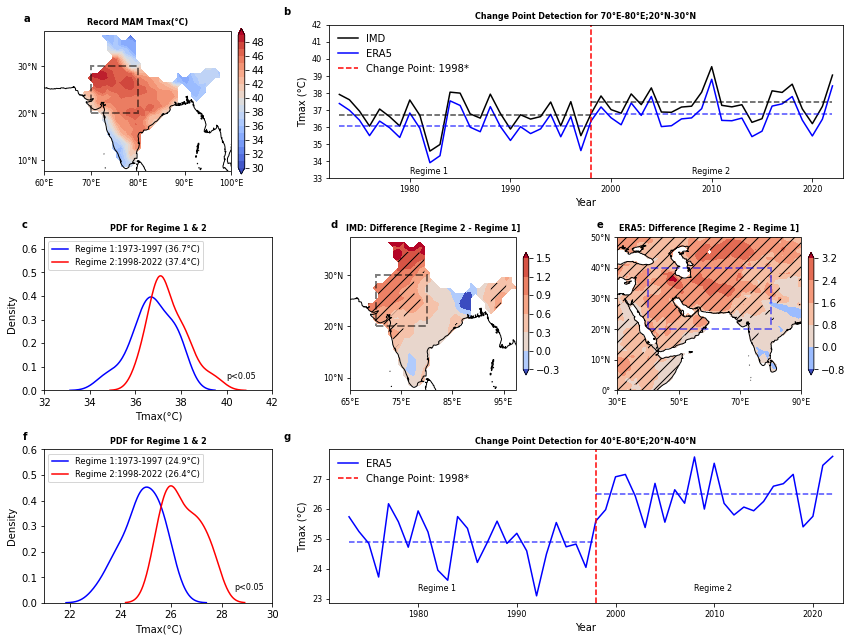

In [265]:
############################### Plotting ##########################################
fig = plt.figure(figsize=(12,9))
######################## For the first subplot, we specify the projection
ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=1, fig=fig, projection=ccrs.PlateCarree())

clevs=np.arange(30,50,1)
cf_plot = ax1.contourf(t_Max_1973_2022.lon, t_Max_1973_2022.lat, t_Max_1973_2022, clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = fig.colorbar(cf_plot,ax=ax1, orientation='vertical', pad=0.03, shrink=0.95)
#cbar.set_label('°C')

rect_coords = [70, 20, 80, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
# Add a rectangular box to the plot with specific lat,lon coordinates
rect = Rectangle((lon_min, lat_min), width, height, linewidth=2, linestyle='--', edgecolor='k', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

ax1.coastlines()
# Longitude labels
ax1.set_xticks(np.arange(60,105,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax1.set_yticks(np.arange(10,40,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('Record MAM Tmax(°C)',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

###################### For the second subplot, a simple line plot
ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 1), colspan=2, fig=fig)

ax2.plot(years, t_imd,label="IMD",color='black')
ax2.plot(years, t_era5,label="ERA5",color='blue')
ax2.axvline(x=years[cp_era-1], color='r', linestyle='--', label=f'Change Point: {cp_year_era}*')

ax2.plot([1973, years[cp_imd-1]], [mu1_imd, mu1_imd], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_imd}')
ax2.plot([years[cp_imd-1],2022], [mu2_imd, mu2_imd], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 2 Mean: {mu2_imd}')

ax2.plot([1973, years[cp_era-1]], [mu1_era, mu1_era], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax2.plot([years[cp_era-1],2022], [mu2_era, mu2_era], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax2.set_xlim(1972,2023)
ax2.set_ylim(33,42)

ax2.text(1980, 33.25, "Regime 1", fontsize=8)
ax2.text(2008, 33.25, "Regime 2", fontsize=8)
ax2.legend(loc='upper left',frameon=False, ncol=1)
ax2.set_ylabel('Tmax (°C)', fontsize=10)
ax2.set_xlabel('Year', fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_title('Change Point Detection for 70°E-80°E;20°N-30°N',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')


###################### For the third subplot, pdf- regime 1 and 2
ax3 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1, fig=fig)

# Plot the histogram for data1 with a specific color and label
sns.kdeplot(data=data1, ax=ax3, color='blue', alpha=1, label='Regime 1:1973-1997 (36.7°C)')

# Plot the histogram for data2 with a different color and label
sns.kdeplot(data=data2, ax=ax3, color='red', alpha=1, label='Regime 2:1998-2022 (37.4°C)')

ax3.legend(loc='upper left', fontsize='small')
ax3.text(40, 0.05, "p<0.05", fontsize=8)
# Set labels and title
ax3.set_xlabel('Tmax(°C)', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_xlim(32, 42)
ax3.set_ylim(0, 0.65)
ax3.set_title('PDF for Regime 1 & 2',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

##################################

ax4 = plt.subplot2grid(shape=(3, 3), loc=(1, 1), colspan=1, fig=fig, projection=ccrs.PlateCarree())

# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = IMD_Regime.dif.min()
max_value = IMD_Regime.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax4.contourf(IMD_Regime.lon, IMD_Regime.lat, IMD_Regime.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax4,orientation='vertical', pad=0.03, shrink=0.8)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax4.contourf(IMD_Regime.lon, IMD_Regime.lat, pvalue_mask_imd, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

rect_coords = [70, 20, 80, 30]  # [lon_min, lat_min, lon_max, lat_max]

 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='k', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax4.add_patch(rect)

# Add coastlines and gridlines
ax4.coastlines()

# Longitude labels
ax4.set_xticks(np.arange(65,105,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax4.set_yticks(np.arange(10,40,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax4.tick_params(axis='both', which='major', labelsize=8)
# ax4.set_xlabel('Longitude')
# ax4.set_ylabel('Latitude')
# Title
ax4.set_title('IMD: Difference [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax4.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

###################### For the fourth subplot, difference
ax5 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), colspan=1, fig=fig, projection=ccrs.PlateCarree())

# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = ERA5_Regime.dif.min()
max_value = ERA5_Regime.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax5.contourf(ERA5_Regime.lon, ERA5_Regime.lat, ERA5_Regime.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax5,orientation='vertical', pad=0.03, shrink=0.8)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax5.contourf(ERA5_Regime.lon, ERA5_Regime.lat, pvalue_mask_era5, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

rect_coords = [40, 20, 80, 40]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='b', facecolor='none',alpha=0.5, transform=ccrs.PlateCarree())
ax5.add_patch(rect)

# Add coastlines and gridlines
ax5.coastlines()

# Longitude labels
ax5.set_xticks(np.arange(30,105,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax5.set_yticks(np.arange(0,55,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax5.tick_params(axis='both', which='major', labelsize=8)

ax5.set_extent([30, 90, 0, 50],crs=ccrs.PlateCarree())

# ax5.set_xlabel('Longitude')
# ax5.set_ylabel('Latitude')
 
# Title
ax5.set_title('ERA5: Difference [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})

ax5.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

###
ax6 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), colspan=1, fig=fig)

# Plot the histogram for data1 with a specific color and label
sns.kdeplot(data=data1_BB, ax=ax6, color='blue', alpha=1, label='Regime 1:1973-1997 (24.9°C)')

# Plot the histogram for data2 with a different color and label
sns.kdeplot(data=data2_BB, ax=ax6, color='red', alpha=1, label='Regime 2:1998-2022 (26.4°C)')

ax6.text(28.5, 0.05, "p<0.05", fontsize=8)
# Set labels and title
ax6.set_xlabel('Tmax(°C)', fontsize=10)
ax6.set_ylabel('Density', fontsize=10)
ax6.set_xlim(21, 30)
ax6.set_ylim(0, 0.6)
ax6.set_title('PDF for Regime 1 & 2',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax6.legend(loc='upper left', fontsize='small')
ax6.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')

###################### For the second subplot, a simple line plot
ax7 = plt.subplot2grid(shape=(3, 3), loc=(2, 1), colspan=2, fig=fig)

ax7.plot(years, t_era5_BB,label="ERA5",color='blue')
ax7.axvline(x=years[cp_era_BB-1], color='r', linestyle='--', label=f'Change Point: {cp_year_era_BB}*')
ax7.plot([1973, years[cp_era_BB-1]], [mu1_era_BB, mu1_era_BB], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax7.plot([years[cp_era_BB-1],2022], [mu2_era_BB, mu2_era_BB], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax7.set_xlim(1971,2023)
#ax7.set_ylim(33,42)

ax7.text(1980, 23.25, "Regime 1", fontsize=8)
ax7.text(2008, 23.25, "Regime 2", fontsize=8)
ax7.legend(loc='upper left',frameon=False, ncol=1)
ax7.set_ylabel('Tmax (°C)', fontsize=10)
ax7.set_xlabel('Year', fontsize=10)
ax7.tick_params(axis='both', which='major', labelsize=8)

ax7.set_title('Change Point Detection for 40°E-80°E;20°N-40°N',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax7.text(-0.075, 1.05, 'g',verticalalignment='bottom', horizontalalignment='right',transform=ax7.transAxes,color='k', weight='bold')

#fig.subplots_adjust(hspace=0.35, wspace=0.125)
plt.tight_layout()

plt.savefig('Figure_1.jpg', dpi=600,bbox_inches='tight')
plt.savefig('Figure_1.pdf', dpi=600,bbox_inches='tight')

In [98]:
##### 


In [245]:
##Supplementary Figure 1 - option
Tmax_MAM_SS2 = Tmax_MAM.sel(time=slice('1973','2022'))
Tmax_MAM_Mean = Tmax_MAM_SS2.groupby('time.year').mean(dim='time')

t_era5_BB = Tmax_MAM_Mean.t2m.sel(latitude=slice(40,20),longitude=slice(40,80)).mean(dim=['latitude','longitude'])

cp_test_res_BB = pettitt_test(t_era5_BB)
cp_era_BB = cp_test_res_BB.cp
cp_year_era_BB = t_era5_BB.year[cp_era_BB-1].values
mu1_era_BB = round(cp_test_res_BB.avg.mu1,2)
mu2_era_BB = round(cp_test_res_BB.avg.mu2,2)  
pval_era_BB = cp_test_res_BB.p
years = t_era5_BB.year

slope_eraR1,int_eraR1,rvalue_eraR1,pvalue_eraR1,stderr_eraR1 = stats.linregress(years[:cp_era_BB], t_era5_BB[:cp_era_BB])
slope_eraR2,int_eraR2,rvalue_eraR2,pvalue_eraR2,stderr_eraR2 = stats.linregress(years[cp_era_BB-1:], t_era5_BB[cp_era_BB-1:])

####
era_R1_BB = Tmax_MAM_SS2.sel(time = slice("1973","1997"),latitude=slice(40,20),longitude=slice(40,80)).mean(dim=["latitude","longitude"])
era_MAM_R1_BB = era_R1_BB.groupby('time.year').mean(dim='time')

era_R2_BB = Tmax_MAM_SS.sel(time = slice("1998","2022"),latitude=slice(40,20),longitude=slice(40,80)).mean(dim=["latitude","longitude"])
era_MAM_R2_BB = era_R2_BB.groupby('time.year').mean(dim='time')

df1 = era_MAM_R1_BB.to_dataframe()
df2 = era_MAM_R2_BB.to_dataframe()
data1_BB = df1['t2m']
data2_BB = df2['t2m']

# Calculate statistics for data1
mean1_BB = np.mean(data1_BB)
variance1_BB = np.var(data1_BB)
std1_BB= np.std(data1_BB)
skewness1_BB = data1_BB.skew()

# Calculate statistics for data2
mean2_BB = np.mean(data2_BB)
std2_BB= np.std(data2_BB)
variance2_BB = np.var(data2_BB)
skewness2_BB = data2_BB.skew()

##K_S Test
ks_test_result_BB = stats.ks_2samp(data1_BB, data2_BB)

In [250]:
cp_year_era_BB

array(1998)

In [247]:
mean1_BB

24.868858337402344

In [248]:
mean2_BB

26.45035171508789

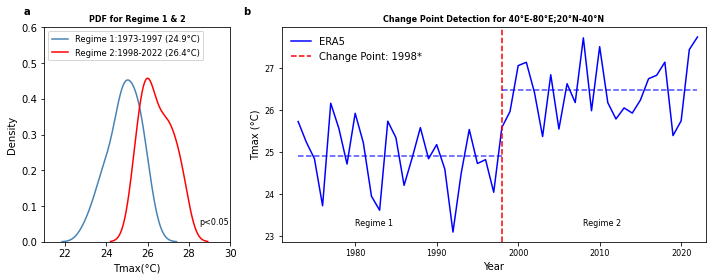

In [251]:
############################### Supplementary Figure 1 ##########################################

fig = plt.figure(figsize=(10,4))

###################### For the third subplot, pdf- regime 1 and 2
ax3 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1, fig=fig)

# Plot the histogram for data1 with a specific color and label
sns.kdeplot(data=data1_BB, ax=ax3, color='steelblue', alpha=1, label='Regime 1:1973-1997 (24.9°C)')

# Plot the histogram for data2 with a different color and label
sns.kdeplot(data=data2_BB, ax=ax3, color='red', alpha=1, label='Regime 2:1998-2022 (26.4°C)')

ax3.text(28.5, 0.05, "p<0.05", fontsize=8)
# Set labels and title
ax3.set_xlabel('Tmax(°C)', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_xlim(21, 30)
ax3.set_ylim(0, 0.6)
ax3.set_title('PDF for Regime 1 & 2',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax3.legend(loc='upper left', fontsize='small')
ax3.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###################### For the second subplot, a simple line plot
ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2, fig=fig)

ax2.plot(years, t_era5_BB,label="ERA5",color='blue')
ax2.axvline(x=years[cp_era_BB-1], color='r', linestyle='--', label=f'Change Point: {cp_year_era_BB}*')
ax2.plot([1973, years[cp_era_BB-1]], [mu1_era_BB, mu1_era_BB], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax2.plot([years[cp_era_BB-1],2022], [mu2_era_BB, mu2_era_BB], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax2.set_xlim(1971,2023)
#ax2.set_ylim(33,42)

ax2.text(1980, 23.25, "Regime 1", fontsize=8)
ax2.text(2008, 23.25, "Regime 2", fontsize=8)
ax2.legend(loc='upper left',frameon=False, ncol=1)
ax2.set_ylabel('Tmax (°C)', fontsize=10)
ax2.set_xlabel('Year', fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_title('Change Point Detection for 40°E-80°E;20°N-40°N',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

#fig.subplots_adjust(hspace=0.35, wspace=0.125)
plt.tight_layout()

#plt.savefig('SFig_1.png', dpi=600,bbox_inches='tight')
#plt.savefig('SFig_1.pdf', dpi=600,bbox_inches='tight')
